In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from datetime import datetime,timedelta
import pandas as pd
import seaborn as sns
import io
from google.colab import files

In [2]:
uploaded = files.upload()

Saving train_anonimized .csv to train_anonimized .csv


In [3]:
data= pd.read_csv('train_anonimized .csv',parse_dates=['DATE'])

<ipython-input-3-fccd7e893a17>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data= pd.read_csv('train_anonimized .csv',parse_dates=['DATE'])


In [4]:
count_null = pd.DataFrame(data.isnull().sum(), columns = ['Null Values'])
count_null

,Null Values
Unnamed: 0,0
NAICS_DESC,28162
DATE,0
REVENUE,0
anonimized_name,0


In [5]:
data.fillna('Unknown', inplace = True)

In [6]:
from datetime import datetime

import datetime
snapshot_date=max(data.DATE)+datetime.timedelta(days=1)

clients=data.groupby(['anonimized_name']).agg({'DATE': lambda x:
                                             (snapshot_date-x.max()).days,
                                             'NAICS_DESC':'count',
                                             'REVENUE':'sum'})
clients.rename(columns={'DATE':'Recency',
                          'NAICS_DESC':'Frequency',
                          'REVENUE':'MonetaryValue'}, inplace=True)

In [7]:
#Building RFM segments
R_labels=range(1,3)
F_labels=range(1,5)
M_labels=range(1,5)

R_quartiles=pd.cut(clients['Recency'],bins=2,labels=R_labels)
F_quartiles = pd.qcut(clients['Frequency'],q=4,labels=F_labels)
M_quartiles = pd.qcut(clients['MonetaryValue'],q=4,labels=M_labels)

RFM=clients.assign(R=R_quartiles,F=F_quartiles,M=M_quartiles)

In [8]:
# Build RFM Segment and RFM Score
def add_rfm(x) : return str(x['R'])+str(x['F']) + str(x['M'])

RFM['RFM_Segment'] = RFM.apply(add_rfm,axis=1 )
RFM['RFM_Score'] = RFM[['R','F','M']].sum(axis=1)

In [9]:
RFM.sample(5)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
anonimized_name,,,,,,,,
Teresa Haynes INC,2,1018,2556418,1,3,2,132,6
Gary Nguyen INC,10,685,2662090,1,2,2,122,5
Daniel George INC,2,1088,3630949,1,3,3,133,7
Rebecca Castro INC,2,688,2486068,1,2,2,122,5
Lisa Wilson INC,2,1814,2420801,1,4,2,142,7


In [10]:
RFM.groupby('RFM_Score').agg({'Recency':'mean',
                             'Frequency':'mean',
                             'MonetaryValue': ['mean', 'count'] }).round(2)

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3            2.00    301.00    1532937.50     6
4            2.00    709.50    1659039.00     4
5            3.33    852.83    2792559.33     6
6            4.43   1015.07    7159852.29    14
7            2.71   1499.43    4334896.64    14
8            1.40   1599.80   10002251.20     5
9            1.67   2122.33   10909006.00     3

# Segmentation Based on RFM Score

In [11]:
def segments(df):
    if df['RFM_Score'] >= 8:
        return 'Svip'
    elif (df['RFM_Score'] > 5) and (df['RFM_Score'] <= 7 ):
        return 'Vip'
    elif (df['RFM_Score']>3) and (df['RFM_Score']<=5):
        return 'Normal'
    else:
        return 'New'

RFM['Segmentations'] =RFM.apply(segments,axis=1)

In [12]:
RFM.sample(5)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,Segmentations
anonimized_name,,,,,,,,,
Renee Fisher INC,3,1212,3641035,1,3,3,133,7,Vip
Amy Dunn INC,1,554,9097093,1,1,4,114,6,Vip
Stephanie Gregory INC,2,140,1545854,1,1,1,111,3,New
Caleb Davidson INC,1,424,19889730,1,1,4,114,6,Vip
James Sandoval INC,2,1612,2510905,1,4,2,142,7,Vip


In [13]:
# Average revenue per customer
segments = RFM.reset_index().groupby('Segmentations').agg({'Recency':'mean',
                                                'Frequency':'mean',
                                                'MonetaryValue': 'sum',
                                                'anonimized_name': 'count'})

In [14]:
segments.head()
arpc = segments['MonetaryValue'] / segments['anonimized_name']
arpc

Segmentations
New       1.532938e+06
Normal    2.339151e+06
Svip      1.034228e+07
Vip       5.747374e+06
dtype: float64

In [15]:
RFM_segment=RFM.loc[:,['RFM_Score','Segmentations']]
RFM_segment.sort_values(by='RFM_Score', ascending=True)

,RFM_Score,Segmentations
anonimized_name,,
Tony Lloyd INC,3,New
Jason Brown INC,3,New
Stephanie Gregory INC,3,New
Andrew Patterson INC,3,New
Cory Cooper INC,3,New
Miss Amanda Harris MD INC,3,New
Morgan Foster INC,4,Normal
Stephen Martin INC,4,Normal
Jessica Hernandez INC,4,Normal


In [16]:
RFM_segment=RFM_segment.reset_index()

Text(0, 0.5, 'Clients')

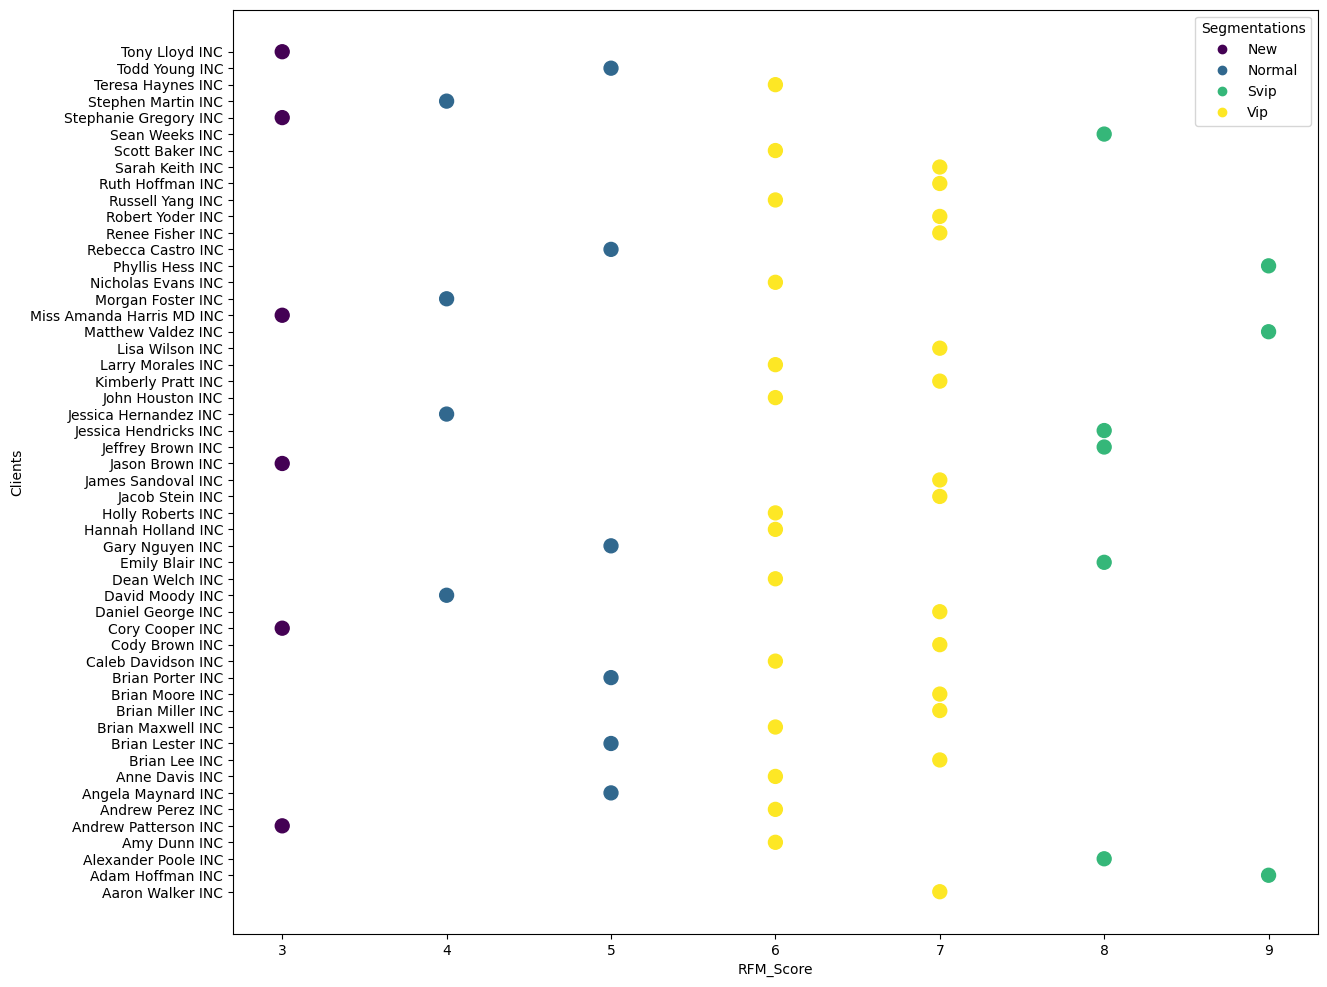

In [17]:
x=RFM_segment['RFM_Score']
y=RFM_segment['anonimized_name']
z=RFM_segment['Segmentations']
segmentation_name=['New','Normal','Svip','Vip']

plt.figure(figsize=(14,12))
plt.ticklabel_format(style = 'plain')
scatter = plt.scatter(x,
            y,
            s=100,
            c=RFM_segment.Segmentations.astype('category').cat.codes)
plt.legend(handles=scatter.legend_elements()[0],
           labels = segmentation_name,
           title="Segmentations")
plt.xlabel('RFM_Score')
plt.ylabel('Clients')

# Check Skewness & Scaling

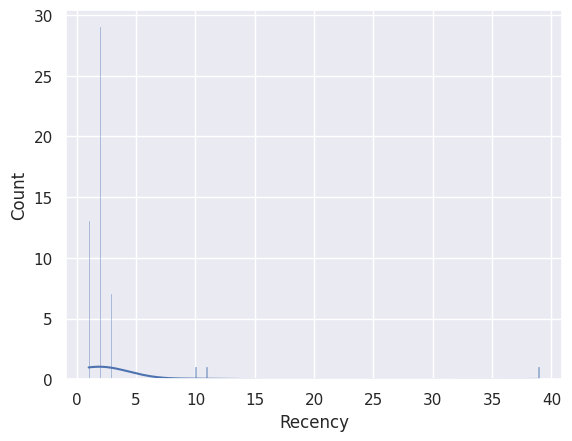

In [18]:
#Recency
sns.set(style="darkgrid")
sns.histplot(clients, x='Recency',kde=True)
plt.show()

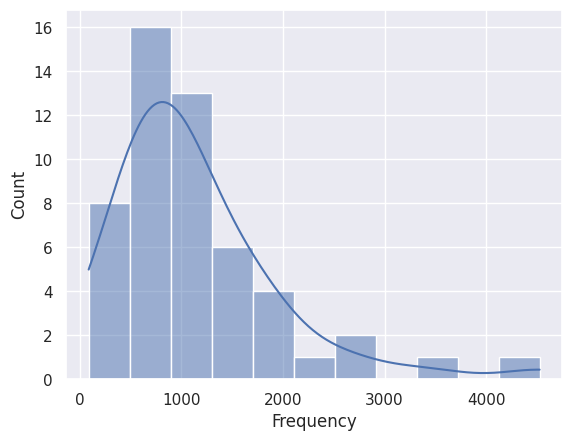

In [19]:
#Frequency
sns.set(style="darkgrid")
sns.histplot(clients, x='Frequency',kde=True)
plt.show()

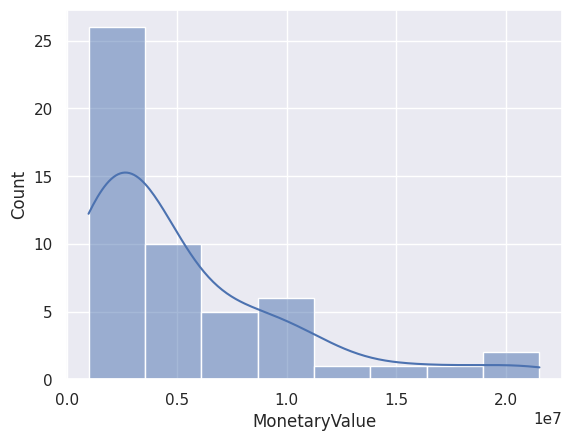

In [20]:
sns.set(style="darkgrid")
sns.histplot(clients, x='MonetaryValue',kde=True)
plt.show()

In [21]:
#Orginal Skewness
from scipy.stats import skew
Orginal_Recency_Skewness=skew(clients['Recency'],bias=False)
print('Original Recency Skweness is:',Orginal_Recency_Skewness)

Orginal_Frequency_Skewness=skew(clients['Frequency'],bias=False)
print('Original Frequency Skweness is:',Orginal_Frequency_Skewness)

Orginal_MonetaryValue_Skewness=skew(clients['MonetaryValue'],bias=False)
print('Original MonetaryValue Skweness is:',Orginal_MonetaryValue_Skewness)

Original Recency Skweness is: 6.164393730234404
Original Frequency Skweness is: 1.9568795383475186
Original MonetaryValue Skweness is: 1.7506847432626318


# Prepare Clusting

In [22]:
# box_cox Transformation
from scipy.stats import boxcox

boxcox_Recency_Skewness=boxcox(clients['Recency'])[0]
print('boxcox Recency Skweness is:',skew(boxcox_Recency_Skewness))

boxcox_Frequency_Skewness=boxcox(clients['Frequency'])[0]
print('boxcox Frequency Skweness is:',skew(boxcox_Frequency_Skewness))

boxcox_MonetaryValue_Skewness=boxcox(clients['MonetaryValue'])[0]
print('boxcox MonetaryValue Skweness is:',skew(boxcox_MonetaryValue_Skewness))

boxcox Recency Skweness is: -0.022487791233578275
boxcox Frequency Skweness is: 0.03323484309486011
boxcox MonetaryValue Skweness is: 0.07409561671440483


In [23]:
#Use box_cox Transformation
from scipy import stats
rfm_boxcox = pd.DataFrame()
rfm_boxcox["Recency"] = stats.boxcox(clients['Recency'])[0]
rfm_boxcox["Frequency"] = stats.boxcox(clients['Frequency'])[0]
rfm_boxcox["MonetaryValue"] = stats.boxcox(clients['MonetaryValue'])[0]
rfm_boxcox.sample(5)

,Recency,Frequency,MonetaryValue
49,0.549860,18.013364,3.343261
16,0.549860,15.347337,3.335586
22,0.549860,14.150449,3.358059
42,0.767905,15.073574,3.359281
19,0.549860,16.640575,3.347948


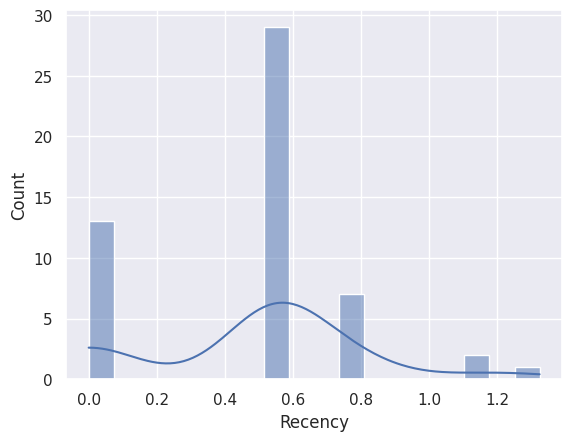

In [24]:
#Recency after transformation
sns.set(style="darkgrid")
sns.histplot(rfm_boxcox, x='Recency',kde=True)
plt.show()

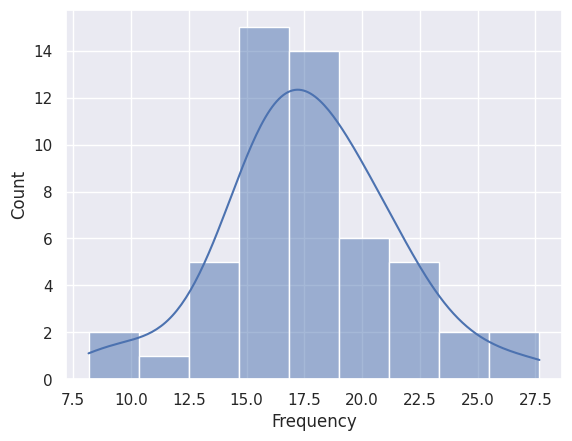

In [25]:
#Frequency after transformation
sns.set(style="darkgrid")
sns.histplot(rfm_boxcox, x='Frequency',kde=True)
plt.show()

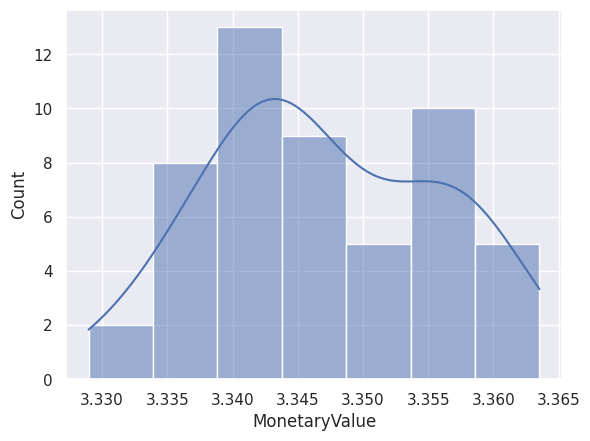

In [26]:
#MonetaryValue after transformation
sns.set(style="darkgrid")
sns.histplot(rfm_boxcox, x='MonetaryValue',kde=True)
plt.show()

In [27]:
#normalization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(rfm_boxcox)

rfm_normalized= scaler.transform(rfm_boxcox)

print(rfm_normalized.mean(axis=0).round(2))
print(rfm_normalized.std(axis=0).round(2))
rfm_normalized[1:6,:]

[-0. -0. -0.]
[1. 1. 1.]


array([[ 0.21795351,  1.26403489,  0.98462288],
       [-1.49699742,  0.05232078,  1.87542773],
       [-1.49699742, -0.73221577,  1.1120403 ],
       [-1.49699742, -1.94015854, -0.97654582],
       [-1.49699742, -0.42780665,  0.20391864]])

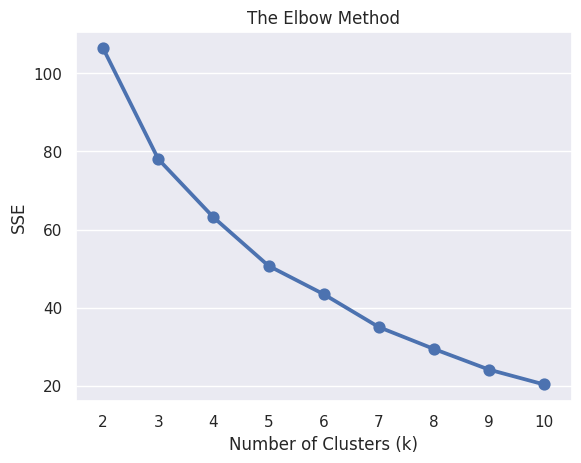

In [28]:
#k-means algorithm
from sklearn.cluster import KMeans
sse = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_normalized)
    sse[k] = kmeans.inertia_
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [29]:
model=KMeans(n_clusters=4, random_state=42, n_init=10)
model.fit(rfm_normalized)

KMeans(n_clusters=4, n_init=10, random_state=42)

In [30]:
#Interpre the Segment
clients['Cluster']=model.labels_
clients.groupby('Cluster').agg({'Recency':'mean',
                               'Frequency':'mean',
                               'MonetaryValue':['mean', 'count']}).round(2)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          1.00   1069.82   10328692.27    11
1          2.00    484.73    1665440.82    11
2          2.73   1954.18    2226690.91    11
3          4.68   1091.26    6306570.11    19

In [31]:
df_normalized = pd.DataFrame(rfm_normalized, columns=['Recency','Frequency','MonetaryValue'])
df_normalized['anonimized_name'] = clients.index
df_normalized['Cluster'] =model.labels_

#Melt the data
df_normalized_melt = pd.melt(df_normalized.reset_index(),
                             id_vars=['anonimized_name','Cluster'],
                             value_vars=['Recency', 'Frequency', 'MonetaryValue'],
                             var_name='Metric',value_name='Value')

df_normalized_melt.sample(5)

,anonimized_name,Cluster,Metric,Value
68,Cory Cooper INC,1,Frequency,-0.631612
122,David Moody INC,1,MonetaryValue,-2.064906
74,Hannah Holland INC,3,Frequency,-0.954121
113,Brian Lester INC,0,MonetaryValue,0.466343
90,Phyllis Hess INC,3,Frequency,0.845373


<Axes: xlabel='Metric', ylabel='Value'>

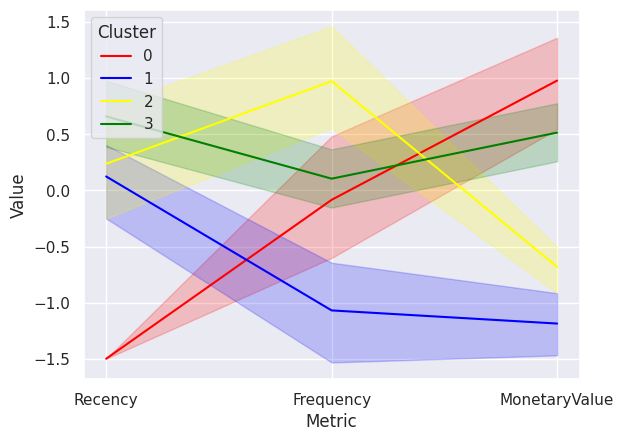

In [32]:
sns.lineplot(x='Metric',y='Value', hue='Cluster',palette=['red','blue','yellow','green'], data=df_normalized_melt)